Appenddix
-click on the link:
>1. <a href=#Imports> Imports</a>
>2. <a href=#Load> Load Data</a>
>3. <a href=#Datapr> Data Preprocessing</a>
>4. <a href=#trainM> Training the Models</a>
>5. <a href=#Trans> Transfer Learning Model</a>
>6. <a href=#res> Results</a>

## <a name=#Imports style=" font-size:150%;"> Libraries Imports </a>

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#Data Preprocessing

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop


import wget
url = 'http://www.futurecrew.com/skaven/song_files/mp3/razorback.mp3'
filename = wget.download(url)

filename
'razorback.mp3'


'razorback.mp3'

## <a name=#Load> Load Data </a>

In [9]:
base_dir = 'DATASET'
train_dir = os.path.join(base_dir, 'TRAIN')
validation_dir = os.path.join(base_dir, 'TEST')

# Directory with training organic pictures
train_organic_dir = os.path.join(train_dir, 'O')

# Directory with training recyclable pictures
train_recycle_dir = os.path.join(train_dir, 'R')

# Directory with validation organic pictures
validation_organic_dir = os.path.join(validation_dir, 'O')

# Directory with validation recyclable pictures
validation_recycle_dir = os.path.join(validation_dir, 'R')

print('total training organic images:', len(os.listdir(train_organic_dir)))
print('total training recycyle images:', len(os.listdir(train_recycle_dir)))
print('total validation organic images:', len(os.listdir(validation_organic_dir)))
print('total validation recycyle images:', len(os.listdir(validation_recycle_dir)))

total training organic images: 12565
total training recycyle images: 9999
total validation organic images: 1401
total validation recycyle images: 1112


## We'll need to know the image shapes for the machine learning model, so I took a look at some samples:

(225, 225, 3)
(224, 224, 3)
(191, 264, 3)
(168, 300, 3)
(160, 314, 3)
(150, 300, 3)
(187, 269, 3)
(168, 300, 3)


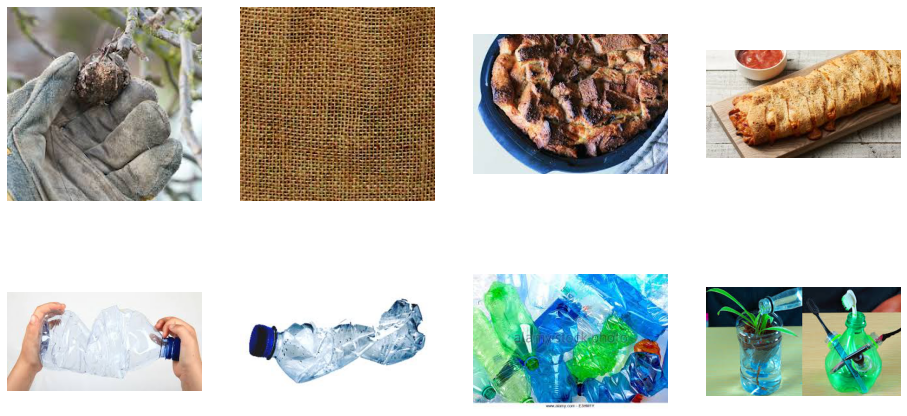

In [10]:
train_organic_fnames = os.listdir(train_organic_dir)
train_recycle_fnames = os.listdir(train_recycle_dir)
train_recycle_fnames.sort()

%matplotlib inline

# Parameters for our graph; we'll output images in a 2x4 configuration
nrows = 2
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 2x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows *4)

pic_index += 4
next_organic_pix = [os.path.join(train_organic_dir, fname) 
                for fname in train_organic_fnames[pic_index-4:pic_index]]
next_recycle_pix = [os.path.join(train_recycle_dir, fname) 
                for fname in train_recycle_fnames[pic_index-4:pic_index]]

for i, img_path in enumerate(next_organic_pix + next_recycle_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    print(img.shape)

plt.show()

# <a name=#Datapr> Data Preprocessing</a>

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,               # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        shuffle=True,
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        shuffle=True,
        class_mode='binary')

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


# <a name=#trainM> Training the Models</a>

In [12]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_94 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_95 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_96 (Conv2D)          (None, 34, 34, 64)        18496 

In [89]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

history = model.fit(
      train_generator,
      epochs=8,
      validation_data=validation_generator,
      verbose=2,
      shuffle=True)

Epoch 1/8
706/706 - 329s - loss: 0.5170 - acc: 0.7892 - val_loss: 0.4714 - val_acc: 0.7955 - 329s/epoch - 466ms/step
Epoch 2/8
706/706 - 321s - loss: 0.3920 - acc: 0.8368 - val_loss: 0.3694 - val_acc: 0.8687 - 321s/epoch - 454ms/step
Epoch 3/8
706/706 - 301s - loss: 0.3614 - acc: 0.8546 - val_loss: 0.5141 - val_acc: 0.8273 - 301s/epoch - 427ms/step
Epoch 4/8
706/706 - 299s - loss: 0.3475 - acc: 0.8601 - val_loss: 0.4451 - val_acc: 0.8464 - 299s/epoch - 424ms/step
Epoch 5/8
706/706 - 298s - loss: 0.3375 - acc: 0.8674 - val_loss: 0.3431 - val_acc: 0.8786 - 298s/epoch - 422ms/step
Epoch 6/8
706/706 - 296s - loss: 0.3320 - acc: 0.8686 - val_loss: 0.2671 - val_acc: 0.8961 - 296s/epoch - 420ms/step
Epoch 7/8
706/706 - 331s - loss: 0.3252 - acc: 0.8736 - val_loss: 0.3277 - val_acc: 0.8679 - 331s/epoch - 468ms/step
Epoch 8/8
706/706 - 302s - loss: 0.3179 - acc: 0.8774 - val_loss: 0.2910 - val_acc: 0.8890 - 302s/epoch - 428ms/step


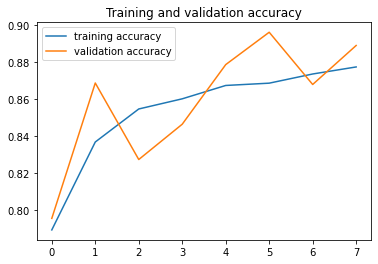

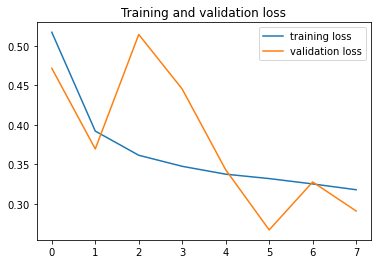

In [90]:
#@title Graphing accuracy and loss
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training and validation loss')
plt.legend()

# <a name=#Trans>Transfer Learning Model</a>


In [5]:
# loading in the Inception v3 model

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import SGD


pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)



for layer in pre_trained_model.layers:
    layer.trainable = False


last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [14]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
    if unfreeze:
        layer.trainable = True
    if layer.name == 'mixed6':
        unfreeze = True

# Configure the model
model = Model(pre_trained_model.input, x)

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

/Users/saraaltamimi/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [93]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1704 (Conv2D)           (None, 74, 74, 32)   864         ['input_23[0][0]']               
                                                                                                  
 batch_normalization_1692 (Batc  (None, 74, 74, 32)  96          ['conv2d_1704[0][0]']            
 hNormalization)                                                                                  
                                                                                            

In [94]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=60,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

<ipython-input-94-04806f39acc0>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/60
100/100 - 151s - loss: 0.6763 - acc: 0.6056 - val_loss: 0.6944 - val_acc: 0.4431 - 151s/epoch - 2s/step
Epoch 2/60
100/100 - 127s - loss: 0.5858 - acc: 0.7100 - val_loss: 0.6932 - val_acc: 0.4569 - 127s/epoch - 1s/step
Epoch 3/60
100/100 - 126s - loss: 0.5568 - acc: 0.7184 - val_loss: 0.6889 - val_acc: 0.5625 - 126s/epoch - 1s/step
Epoch 4/60
100/100 - 127s - loss: 0.5400 - acc: 0.7300 - val_loss: 0.6831 - val_acc: 0.5581 - 127s/epoch - 1s/step
Epoch 5/60
100/100 - 130s - loss: 0.5140 - acc: 0.7550 - val_loss: 0.6653 - val_acc: 0.5544 - 130s/epoch - 1s/step
Epoch 6/60
100/100 - 136s - loss: 0.5083 - acc: 0.7703 - val_loss: 0.6122 - val_acc: 0.6194 - 136s/epoch - 1s/step
Epoch 7/60
100/100 - 128s - loss: 0.5099 - acc: 0.7559 - val_loss: 0.5306 - val_acc: 0.7513 - 128s/epoch - 1s/step
Epoch 8/60
100/100 - 129s - loss: 0.4893 - acc: 0.7703 - val_loss: 0.4372 - val_acc: 0.8256 - 129s/epoch - 1s/step
Epoch 9/60
100/100 - 128s - loss: 0.4836 - acc: 0.7766 - val_loss: 0.4043 - val_

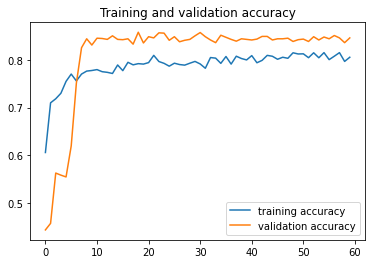

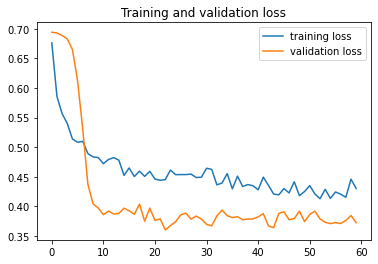

In [95]:
#@title Graphing accuracy and loss
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training and validation loss')
plt.legend()

## <a name=#res> Results</a>

In [15]:
# Flow validation images using val_datagen generator
val_visual = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        class_mode='binary',
        shuffle=True)

print(val_visual.class_indices)

Found 2513 images belonging to 2 classes.
{'O': 0, 'R': 1}


In [16]:
val_pred_prob = model.predict(val_visual)

### Organic samples correspond to the label 0, while recyclable samples correspond to 1. Out of the 2224 validation images, our model misclassified 197.

In [17]:
# must get index array before getting predictions!
val_dir_indices = val_visual.index_array
val_true_labels = [0 if n < 1112 else 1 for n in val_dir_indices] # directory is sorted alphanumerically; 1st 1112: 'O', 2nd 1112: 'R'

# getting predictions in the form of probablities 
val_pred_prob = model.predict(val_visual)

# converting the probablities into binary values 
val_pred_labels = [1 if n >= 0.5 else 0 for n in val_pred_prob]

print("Model predictions: "+str(val_pred_labels))
print("Actual labels:     "+str(val_true_labels))

# determining the filepaths of misclassified waste
num_misclasssified = 0
misclassified_filepaths = []
correctness = []
for pred_label, true_label, dir_index in zip(val_pred_labels, val_true_labels, val_visual.index_array):
    misclassified_filepaths.append(val_visual.filepaths[dir_index])
    if pred_label != true_label:
        correctness.append('incorrect')
        num_misclasssified += 1
    else:
        correctness.append('correct')

print("# of total images: "+str(len(correctness)))
print("# of misclassified images: "+str(num_misclasssified))

Model predictions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### visualize these results, let’s output the images of the classified waste along with correctness

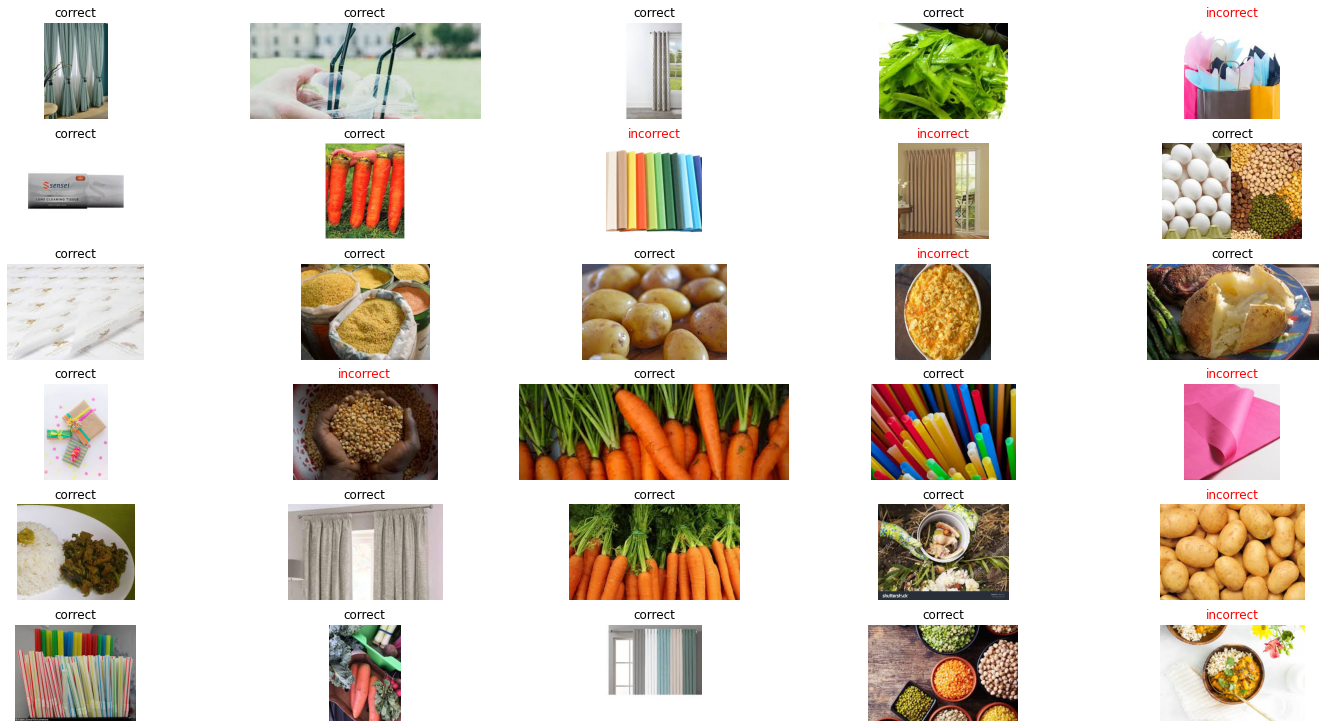

In [100]:
# obtain images from the filepath at the determined indices
misclassified_imgs = []
for filepath in misclassified_filepaths:
    misclassified_imgs.append(mpimg.imread(filepath))

# plot first 30 images
f, axarr = plt.subplots(6,5, figsize=(20,10), constrained_layout=True)  # plt.subplots(row,cols)
count = 0
for r in range(6):
    for c in range(5):
        axarr[r,c].imshow(misclassified_imgs[count])
        if correctness[count] == 'correct':
              axarr[r,c].set_title(correctness[count])
        else:
              axarr[r,c].set_title(correctness[count], color='red')
        axarr[r,c].set_axis_off()
        count += 1 
plt.show()

### I can also evaluate the performance of my model using other metrics. using evaluate()

In [101]:
loss, acc = model.evaluate(validation_generator, verbose=1)
print("Accuracy using evaluate: "+str(acc))
print("Loss using evaluate: "+str(loss)) 

79/79 [==============================] - 49s 614ms/step - loss: 0.3806 - acc: 0.8436
Accuracy using evaluate: 0.8436132073402405
Loss using evaluate: 0.3806073069572449


### I can also create a confusion matrix and a classification report with more details:


In [18]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# confusion matrix
matrix = confusion_matrix(val_true_labels, val_pred_labels, labels=[0, 1])
print('Confusion matrix : \n',matrix, '\n')

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(val_true_labels, val_pred_labels, labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn, '\n')

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(val_true_labels, val_pred_labels, labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[   0 1112]
 [   0 1401]] 

Outcome values : 
 1401 0 1112 0 

Classification report : 
               precision    recall  f1-score   support

           1       0.56      1.00      0.72      1401
           0       0.00      0.00      0.00      1112

    accuracy                           0.56      2513
   macro avg       0.28      0.50      0.36      2513
weighted avg       0.31      0.56      0.40      2513



/Users/saraaltamimi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saraaltamimi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saraaltamimi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)